In [0]:
import torch
import torch.nn as n
import torch.nn.functional as f
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as op
import gym

In [0]:
!pip install ptan

     |████████████████████████████████| 773.1MB 21kB/s 
  Created wheel for ptan: filename=ptan-0.6-cp36-none-any.whl size=23502 sha256=da131defd76f885b38af7cc7e694666cd5c7795d70948ab19b47b9e3a5d36d07
  Stored in directory: /root/.cache/pip/wheels/f0/4b/2f/9a45fd39b0a614a2716bc6128a7f1adb4647f323a2d90783f2
Successfully built ptan
ERROR: torchvision 0.5.0 has requirement torch==1.4.0, but you'll have torch 1.3.0 which is incompatible.
  Found existing installation: torch 1.4.0
    Uninstalling torch-1.4.0:
      Successfully uninstalled torch-1.4.0


In [0]:
import ptan
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [0]:
class scaled(gym.ObservationWrapper):
  def __init__(self,env):
    super().__init__(env)
    self.env=env
  
  def observation(self,x):
    return np.array(x).astype(np.float32)/255.0

In [0]:
env=gym.make("PongNoFrameskip-v4")
env=ptan.common.wrappers.wrap_dqn(env)
env=scaled(env)

/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [0]:
env.action_space.n

6

In [0]:
obsdim=env.observation_space.shape[0]
nactions=env.action_space.n

In [0]:
class net(n.Module):
  def __init__(self,inputshape,nactions):
    super().__init__()
    self.cnn1=n.Conv2d(4,32,kernel_size=8,stride=4)
    self.cnn2=n.Conv2d(32,64,kernel_size=4,stride=2)
    self.cnn3=n.Conv2d(64,128,kernel_size=4,stride=2)
    len1=self.getconvshape(inputshape)
    self.fc1=n.Linear(len1,128)
    self.fc2=n.Linear(128,nactions)

  def getconvshape(self,inputshape):
    x=torch.zeros(1,inputshape[0],inputshape[1],inputshape[2])
    out=self.cnn3(self.cnn2(self.cnn1(x)))
    return out.shape[1]*out.shape[2]*out.shape[3]

  def forward(self,x):
    out=f.relu(self.cnn1(x))
    out=f.relu(self.cnn2(out))
    out=f.relu(self.cnn3(out))
    out=n.Flatten(1,-1)(out)
    out=f.relu(self.fc1(out))
    return self.fc2(out)

In [0]:
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [0]:
model=net([4,84,84],6).to(device)

In [0]:
model

net(
  (cnn1): Conv2d(4, 32, kernel_size=(8, 8), stride=(4, 4))
  (cnn2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
  (cnn3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2))
  (fc1): Linear(in_features=1152, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=6, bias=True)
)

In [0]:
#Testing model
x=torch.zeros(1,4,84,84)
model(x).shape

torch.Size([1, 6])

In [0]:
eps=0.1
gamma=0.99

In [0]:
epsselector=ptan.actions.EpsilonGreedyActionSelector(epsilon=eps)
agent=ptan.agent.DQNAgent(model,epsselector,device=device)

In [0]:
expsource=ptan.experience.ExperienceSourceFirstLast(env,agent,gamma=gamma,steps_count=2)

In [0]:
count=0
for exp in expsource:
  
  if exp.last_state is None:
    print(expsource.pop_total_rewards())
    print(exp.last_state)
    print(exp.reward)
    print(count)
    print("---")

  count+=1           # 2 consecutive are having last_state as None
  if count==1000:
    break

[]
None
-0.99
828
---
[]
None
-1.0
829
---


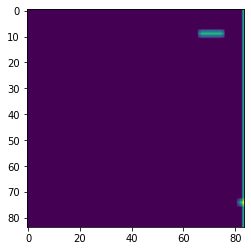

In [0]:
plt.imshow(exp.last_state[0].squeeze())

In [0]:
buffer=ptan.experience.ExperienceReplayBuffer(expsource,buffer_size=50000)

In [0]:
optimizer=op.Adam(model.parameters(),lr=0.001)

In [0]:
frameidx=0


In [0]:
def unpackbatch(batch):
  states,actions,rewards,dones,nextstate=[],[],[],[],[]
  for e in batch:
    states.append(np.array(e.state,copy=False))
    actions.append(np.array(e.action,copy=False))
    rewards.append(np.array(e.reward,copy=False))
    dones.append(np.array(e.last_state is None,dtype=np.uint8))
    if e.last_state is None:
      nextstate.append(np.array(e.state,copy=False))
    else:
      nextstate.append(np.array(e.last_state,copy=False))
  
  return np.array(states),np.array(actions),np.array(rewards),np.array(dones),np.array(nextstate)

In [0]:
tgtmodel=ptan.agent.TargetNet(model)

In [0]:
def calcloss(batch,net,tgtnet,gamma,device):
  batchs,batcha,batchrew,batchdon,batchns=unpackbatch(batch)
  batchs=torch.tensor(batchs).to(device)
  batcha=torch.tensor(batcha).to(device)
  batchrew=torch.tensor(batchrew).to(device)
  batchdon=torch.BoolTensor(batchdon).to(device)
  batchns=torch.tensor(batchns).to(device)

  stateqval=net(batchs).gather(1,batcha.unsqueeze(-1)).squeeze(-1)
  nextstateqval=tgtnet(batchns).max(1)[0]
  nextstateqval[batchdon]=0
  return n.MSELoss()(stateqval,batchrew+(gamma*gamma*nextstateqval))

In [0]:
class rewardtracker:
  def __init__(self):
    self.rewards=[]
  
  def give(self,reward,limit):
    self.rewards.append(reward)

    if len(self.rewards)<100:
      return  False
    
    if np.mean(self.rewards[-100:])<limit:
      return False
    
    if np.mean(self.rewards[-100:])>limit:
      return True

In [0]:
rt=rewardtracker()

In [0]:
replayinitial=5000
batchsize=32
targetsyncsize=2000

In [0]:
while True:
  frameidx+=1
  buffer.populate(1)
  newrewards=expsource.pop_total_rewards()
  if newrewards:
    if rt.give(newrewards[0],18):
      break
  
  if len(buffer)<replayinitial:
    continue
  
  optimizer.zero_grad()
  batch=buffer.sample(batchsize)
  lossv=calcloss(batch,model,tgtmodel.target_model,gamma,device)
  if newrewards:
    print(lossv.item())
    print(newrewards[0])
  lossv.backward()
  optimizer.step()

  if frameidx % targetsyncsize==0:
    tgtmodel.sync()

0.08656920944925478
-21.0
0.030555346906131632
-21.0
0.05876761904921238
-21.0
0.031123196274679733
-21.0
0.030092909800693762
-21.0
0.03053132853763269
-20.0
0.0025080709782049643
-21.0
0.030285676805272867
-21.0
0.059566289107457565
-21.0
